# Tool Performance Comparison on Simulated Data

This notebook analyzes tool-specific performance on simulated CRISPR spacer data using the results from the distance metric analysis sweep. We focus on comparing individual tool performance using Hamming distance with threshold ≤5, leveraging the performance results already generated by the `compare-results` command.

## Key Focus Areas:
1. **Per-tool performance metrics** (precision, recall, F1)
2. **Tool-vs-tool comparisons** at different mismatch thresholds
3. **Performance characteristics** across different dataset sizes
4. **False positive and false negative analysis** per tool

This differs from distance_metric_analysis.ipynb which focuses on aggregate tool-independent metrics to compare Hamming vs Edit distance.

In [2]:
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/')

import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
from bench.utils.functions import *
from lets_plot import *
# import altair as alt
import json

LetsPlot.setup_html()
pl.Config.set_tbl_cols(n=-1)

# Configuration - using Hamming distance with threshold 5 as specified
DISTANCE_METRIC = 'hamming'
MAX_THRESHOLD = 5
THRESHOLDS = list(range(0, MAX_THRESHOLD + 1))

# Load tool styles for consistent colors and markers
with open('notebooks/tool_styles.json', 'r') as f:
    TOOL_STYLES = json.load(f)

print(f"Configuration: {DISTANCE_METRIC} distance, thresholds 0-{MAX_THRESHOLD}")
print(f"Loaded tool styles for {len(TOOL_STYLES)} tools")

Configuration: hamming distance, thresholds 0-5
Loaded tool styles for 11 tools


## Load Performance Results

We'll load the performance results generated by the `compare-results` command (from distance_metric_analysis sweep) for each simulation.

In [3]:
def get_tools_run(sim_dir):
    """Detect which tools were actually run by checking for output files."""
    raw_outputs_dir = Path(sim_dir) / "raw_outputs"
    if not raw_outputs_dir.exists():
        return set()
    
    # Map output file patterns to tool names
    tool_patterns = {
        'blastn': 'blastn_output.tsv',
        'bowtie1': 'bowtie1_output.sam',
        'bowtie2': 'bowtie2_output.sam',
        'indelfree_bruteforce': 'indelfree_bruteforce_output.sam',
        'indelfree_indexed': 'indelfree_indexed_output.sam',
        'minimap2': 'minimap2_output.sam',
        'mmseqs2': 'mmseqs_output.tsv',
        'mummer4': 'mummer4_output.sam',
        'sassy': 'sassy.tsv',
        'strobealign': 'strobealign_output.sam',
        'x_mapper': 'x_mapper_output.sam',
    }
    
    tools_run = set()
    for tool, pattern in tool_patterns.items():
        if (raw_outputs_dir / pattern).exists():
            tools_run.add(tool)
    
    return tools_run

def load_performance_results(sim_dir, distance_metric='hamming', max_mismatches=3):
    """Load performance results TSV file for specific metric and threshold.
    
    Fills in zero values for tools that were run but had no matches (missing from TSV).
    Returns None if the simulation was not run at all.
    """
    perf_file = Path(sim_dir) / f'performance_results_{distance_metric}_mm{max_mismatches}.tsv'
    
    # Get tools that were actually run
    tools_run = get_tools_run(sim_dir)
    
    # Check if simulation was run at all
    if not tools_run and not perf_file.exists():
        # Simulation was not run at all
        return None
    
    if not perf_file.exists():
        print(f"Performance results not found: {perf_file}")
        if tools_run:
            print(f"  WARNING: Tools were run but no performance file exists: {sorted(tools_run)}")
        return None
    
    # Load existing results
    df = pl.read_csv(str(perf_file), separator='\t')
    
    # Find tools that were run but are missing from results (had 0 matches)
    tools_in_results = set(df.filter(pl.col('tool') != 'all_tools_combined')['tool'].unique().to_list())
    missing_tools = tools_run - tools_in_results
    
    if missing_tools:
        print(f"  Adding tools with 0 matches to {Path(perf_file).name}: {sorted(missing_tools)}")
        
        # Get ground truth values from the all_tools_combined row if it exists
        combined_row = df.filter(pl.col('tool') == 'all_tools_combined')
        if len(combined_row) > 0:
            ground_truth_planned = combined_row['ground_truth_planned'][0]
            ground_truth_augmented = combined_row['ground_truth_augmented'][0]
            false_negatives_planned = ground_truth_planned
            false_negatives_augmented = ground_truth_augmented
        else:
            # Fallback if no combined row
            ground_truth_planned = 0
            ground_truth_augmented = 0
            false_negatives_planned = 0
            false_negatives_augmented = 0
        
        # Create zero-filled rows for missing tools
        zero_rows = []
        for tool in sorted(missing_tools):
            zero_row = {
                'tool': tool,
                'planned_true_positives': 0,
                'invalid_alignments': 0,
                'positives_not_in_plan': 0,
                'false_negatives_planned': false_negatives_planned,
                'ground_truth_planned': ground_truth_planned,
                'ground_truth_augmented': ground_truth_augmented,
                'all_true_positives': 0,
                'precision_planned': 0.0,
                'recall_planned': 0.0,
                'false_negatives_augmented': false_negatives_augmented,
                'precision_augmented': 0.0,
                'recall_augmented': 0.0,
            }
            zero_rows.append(zero_row)
        
        # Add zero rows to dataframe
        if zero_rows:
            zero_df = pl.DataFrame(zero_rows)
            df = pl.concat([df, zero_df])
    
    return df

def format_num(n):
    """Format numbers for display (e.g., 100000 -> 100k)"""
    if n >= 1000000:
        return f"{n//1000000}M"
    elif n < 1000:
        return f"{n}"
    else:
        return f"{n//1000}k"

# Find all simulation directories
simulated_base_dir = "results/simulated"
simulation_dirs = sorted(glob.glob(os.path.join(simulated_base_dir, "ns_*")))

# Create simulation name mapping
SIMULATION_NAMES = {}
valid_sim_dirs = []

for sim_dir in simulation_dirs:
    sim_data_dir = Path(sim_dir) / "simulated_data"
    if not sim_data_dir.exists():
        continue
        
    prefix = os.path.basename(sim_dir)
    parts = prefix.split('_')
    
    if len(parts) >= 4:
        try:
            n_spacers = int(parts[1])
            n_contigs = int(parts[3])
            SIMULATION_NAMES[prefix] = f"{format_num(n_spacers)} spacers × {format_num(n_contigs)} contigs"
            valid_sim_dirs.append(sim_dir)
        except ValueError:
            # Keep as-is if can't parse
            SIMULATION_NAMES[prefix] = prefix
            valid_sim_dirs.append(sim_dir)

print(f"Found {len(SIMULATION_NAMES)} simulations:")
for prefix, desc in sorted(SIMULATION_NAMES.items()):
    print(f"  {prefix}: {desc}")

Found 8 simulations:
  ns_100000_nc_10000: 100k spacers × 10k contigs
  ns_100000_nc_20000: 100k spacers × 20k contigs
  ns_100_nc_50000: 100 spacers × 50k contigs
  ns_3826979_nc_421431_real_baseline: 3M spacers × 421k contigs
  ns_500000_nc_100000: 500k spacers × 100k contigs
  ns_50000_nc_5000: 50k spacers × 5k contigs
  ns_500_nc_5000_HIGH_INSERTION_RATE: 500 spacers × 5k contigs
  ns_75000_nc_5000: 75k spacers × 5k contigs


## Select Primary Simulation for Detailed Analysis

Let's focus on one simulation for detailed tool comparison analysis.

In [5]:
# Select primary simulation - using the 100k spacers × 20k contigs as the main analysis
PRIMARY_SIM = "ns_100000_nc_20000"
primary_sim_dir = f"results/simulated/{PRIMARY_SIM}"

# Also analyze the high insertion rate simulation
HIGH_INS_SIM = "ns_500_nc_5000_HIGH_INSERTION_RATE"
high_ins_sim_dir = f"results/simulated/{HIGH_INS_SIM}"

# Load performance data for primary threshold (3 mismatches)
primary_threshold = 3
perf_df = load_performance_results(primary_sim_dir, DISTANCE_METRIC, primary_threshold)

print(f"Loaded performance results for {PRIMARY_SIM} at threshold={primary_threshold}")
print(f"Shape: {perf_df.shape}")
print(f"\nTools found: {perf_df['tool'].unique().to_list()}")

Loaded performance results for ns_100000_nc_20000 at threshold=3
Shape: (12, 13)

Tools found: ['strobealign', 'all_tools_combined', 'blastn', 'minimap2', 'bowtie2', 'indelfree_indexed', 'x_mapper', 'sassy', 'indelfree_bruteforce', 'mummer4', 'mmseqs2', 'bowtie1']


In [4]:
# View the recall metrics - focus on augmented recall
perf_df.select([
    'tool', 
    'recall_augmented',
    'recall_planned', 
    'planned_true_positives',
    'all_true_positives',
    'false_negatives_planned',
    'ground_truth_augmented'
]).sort('recall_augmented', descending=True)

tool,recall_augmented,recall_planned,planned_true_positives,all_true_positives,false_negatives_planned,ground_truth_augmented
str,f64,f64,i64,i64,i64,i64
"""bowtie1""",1.0,1.0,300084,300248,0,300248
"""indelfree_indexed""",1.0,1.0,300084,300248,0,300248
"""all_tools_combined""",1.0,1.0,300084,300248,0,300248
"""indelfree_bruteforce""",1.0,1.0,300084,300248,0,300248
"""sassy""",0.99996,1.0,300084,300236,0,300248
"""bowtie2""",0.976656,0.97714,293224,293239,6860,300248
"""blastn""",0.779919,0.780128,234104,234169,65980,300248
"""mmseqs2""",0.720611,0.720998,216360,216362,83724,300248
"""strobealign""",0.545409,0.545687,163752,163758,136332,300248


## Tool Recall at Different Hamming Distance Thresholds

Load all thresholds for the primary simulation to see how each tool performs when allowing up to N mismatches. This reveals which tools cannot perform above certain distance thresholds.

In [16]:
# Load performance data for all thresholds
all_threshold_data = []

for threshold in THRESHOLDS:
    df = load_performance_results(primary_sim_dir, DISTANCE_METRIC, threshold)
    if df is not None:
        # Add threshold column
        df = df.with_columns(pl.lit(threshold).alias('threshold'))
        all_threshold_data.append(df)

# Combine all thresholds
combined_perf = pl.concat(all_threshold_data)

# Filter out the aggregate tool
tools_only = combined_perf.filter(pl.col('tool') != 'all_tools_combined')

print(f"Total rows: {tools_only.shape[0]}")
print(f"Unique tools: {tools_only['tool'].n_unique()}")
print(f"Thresholds: {sorted(tools_only['threshold'].unique().to_list())}")

Total rows: 66
Unique tools: 11
Thresholds: [0, 1, 2, 3, 4, 5]


## Visualize Tool Recall at Exact Hamming Distances

Using tool-specific colors and markers from tool_styles.json

In [8]:
# Create color and shape mappings from tool styles for lets-plot
tool_colors = {tool: styles['color'] for tool, styles in TOOL_STYLES.items()}
tool_shapes = {tool: styles['letsplot_shape_num'] for tool, styles in TOOL_STYLES.items()}

print(f"Tool colors: {list(tool_colors.items())[:3]}...")
print(f"Tool shapes: {list(tool_shapes.items())[:3]}...")

Tool colors: [('blastn', '#7C3018'), ('bowtie1', '#0275DC'), ('bowtie2', '#70FC28')]...
Tool shapes: [('blastn', 3), ('bowtie1', 15), ('bowtie2', 17)]...


In [7]:
# Check the data before plotting
print(f"Data shape: {tools_only.shape}")
print("Sample data:")
print(tools_only.select(['tool', 'threshold', 'recall_augmented']).head(20))
print(f"\nTools: {tools_only['tool'].unique().to_list()}")

# Convert polars to dict for lets-plot (doesn't require pandas)
plot_data = tools_only.select(['tool', 'threshold', 'recall_augmented']).to_dict(as_series=False)

# Create interactive plot of recall (augmented) at different hamming distance thresholds
chart = (
    ggplot(plot_data, aes(x='threshold', y='recall_augmented', color='tool', group='tool')) +
    geom_line(size=1.5) +
    geom_point(aes(shape='tool'), size=4) +
    scale_color_manual(values=tool_colors, name='Tool') +
    scale_shape_manual(values=tool_shapes, name='Tool') +
    scale_y_continuous(limits=[0, 1.05]) +
    labs(
        x='Hamming Distance Threshold',
        y='Recall (tool-detected / all valid alignments)',
        title=f'Tool Recall vs Hamming Distance Threshold ({PRIMARY_SIM})'
    ) +
    ggsize(700, 450) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, face='bold'),
        legend_position='right'
    )
)

#save 
mean_recall_output_dir = f"{simulated_base_dir}/plots"
os.makedirs(mean_recall_output_dir, exist_ok=True)
chart.to_html(f"{mean_recall_output_dir}/tool_recall_high_insertion_hamming3.html")
chart.to_svg(f"{mean_recall_output_dir}/tool_recall_high_insertion_hamming3.svg")
chart



Data shape: (66, 14)
Sample data:
shape: (20, 3)
┌──────────────────────┬───────────┬──────────────────┐
│ tool                 ┆ threshold ┆ recall_augmented │
│ ---                  ┆ ---       ┆ ---              │
│ str                  ┆ i32       ┆ f64              │
╞══════════════════════╪═══════════╪══════════════════╡
│ bowtie1              ┆ 0         ┆ 1.0              │
│ indelfree_indexed    ┆ 0         ┆ 1.0              │
│ indelfree_bruteforce ┆ 0         ┆ 1.0              │
│ x_mapper             ┆ 0         ┆ 0.989767         │
│ mummer4              ┆ 0         ┆ 1.0              │
│ strobealign          ┆ 0         ┆ 0.983039         │
│ minimap2             ┆ 0         ┆ 0.001231         │
│ sassy                ┆ 0         ┆ 1.0              │
│ blastn               ┆ 0         ┆ 1.0              │
│ mmseqs2              ┆ 0         ┆ 0.996803         │
│ bowtie2              ┆ 0         ┆ 1.0              │
│ minimap2             ┆ 1         ┆ 0.000613         │

In [8]:
# Save the visualization
output_dir = f"{primary_sim_dir}/plots"
os.makedirs(output_dir, exist_ok=True)

ggsave(chart, f'{output_dir}/tool_recall_exact_hamming.html')
print(f"Saved visualization to {output_dir}/tool_recall_exact_hamming.html")

Saved visualization to results/simulated/ns_100000_nc_20000/plots/tool_recall_exact_hamming.html


## High Insertion Rate Simulation Analysis

Some tools struggle with spacers that have high occurrence rates. Let's analyze the HIGH_INSERTION_RATE simulation to test this.

### Recall vs Number of Occurrences Analysis (HIGH_INSERTION_RATE)

The HIGH_INSERTION_RATE simulation is specifically designed to test how tools perform with spacers that have many occurrences in the reference. Let's analyze whether recall drops as the number of occurrences increases.

In [6]:
# Load high insertion rate simulation data for all thresholds
high_ins_data = []

for threshold in THRESHOLDS:
    df = load_performance_results(high_ins_sim_dir, DISTANCE_METRIC, threshold)
    if df is not None:
        df = df.with_columns(pl.lit(threshold).alias('threshold'))
        high_ins_data.append(df)

# Combine and filter
high_ins_combined = pl.concat(high_ins_data)
high_ins_tools = high_ins_combined.filter(pl.col('tool') != 'all_tools_combined')

print(f"High insertion rate simulation - Total rows: {high_ins_tools.shape[0]}")
print(f"Unique tools: {high_ins_tools['tool'].n_unique()}")
print(f"Thresholds: {sorted(high_ins_tools['threshold'].unique().to_list())}")

  Adding tools with 0 matches to performance_results_hamming_mm0.tsv: ['minimap2']
  Adding tools with 0 matches to performance_results_hamming_mm1.tsv: ['minimap2']
  Adding tools with 0 matches to performance_results_hamming_mm2.tsv: ['minimap2']
  Adding tools with 0 matches to performance_results_hamming_mm3.tsv: ['minimap2']
  Adding tools with 0 matches to performance_results_hamming_mm4.tsv: ['minimap2']
  Adding tools with 0 matches to performance_results_hamming_mm5.tsv: ['minimap2']
High insertion rate simulation - Total rows: 66
Unique tools: 11
Thresholds: [0, 1, 2, 3, 4, 5]


In [9]:
# Plot recall for high insertion rate simulation
high_ins_data_dict = high_ins_tools.select(['tool', 'threshold', 'recall_augmented']).to_dict(as_series=False)

high_ins_chart = (
    ggplot(high_ins_data_dict, aes(x='threshold', y='recall_augmented', color='tool', group='tool')) +
    geom_line(size=1.5) +
    geom_point(aes(shape='tool'), size=4) +
    scale_color_manual(values=tool_colors, name='Tool') +
    scale_shape_manual(values=tool_shapes, name='Tool') +
    scale_y_continuous(limits=[0, 1.05]) +
    labs(
        x='Hamming Distance Threshold (≤)',
        y='Recall (Augmented)',
        title=f'Tool Recall vs Hamming Distance Threshold ({HIGH_INS_SIM})'
    ) +
    ggsize(700, 450) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, face='bold'),
        legend_position='right'
    )
)

mean_recall_output_dir = f"{simulated_base_dir}/plots"
os.makedirs(mean_recall_output_dir, exist_ok=True)
high_ins_chart.to_html(f"{mean_recall_output_dir}/tool_recall_high_insertion_hamming3.html")
high_ins_chart.to_svg(f"{mean_recall_output_dir}/tool_recall_high_insertion_hamming3.svg")
high_ins_chart

high_ins_chart

In [10]:
# Save high insertion rate visualization
high_ins_output_dir = f"{high_ins_sim_dir}/plots"
os.makedirs(high_ins_output_dir, exist_ok=True)

ggsave(high_ins_chart, f'{high_ins_output_dir}/tool_recall_exact_hamming.html')
print(f"Saved high insertion rate visualization to {high_ins_output_dir}/tool_recall_exact_hamming.html")

Saved high insertion rate visualization to results/simulated/ns_500_nc_5000_HIGH_INSERTION_RATE/plots/tool_recall_exact_hamming.html


In [12]:
# Load tool results data for the HIGH_INSERTION_RATE simulation
# We need the actual tool results, not just the performance summary
from bench.utils.tool_commands import load_tool_configs
# Define paths
tool_configs_dir = "tool_configs"
tools = load_tool_configs(tool_configs_dir)

# Filter to tools that have output files in this simulation
raw_outputs_dir = Path(high_ins_sim_dir) / "raw_outputs"
available_tools = {}
for tool_name, tool_config in tools.items():
    output_filename = Path(tool_config['output_file']).name
    output_file = raw_outputs_dir / output_filename
    if output_file.exists():
        available_tools[tool_name] = tool_config.copy()
        available_tools[tool_name]['output_file'] = str(output_file)

print(f"Found {len(available_tools)} tools with results: {list(available_tools.keys())}")

# Load spacer lengths
spacer_file = f"{high_ins_sim_dir}/simulated_data/simulated_spacers.fa"
spacer_lengths_dict = read_fasta(spacer_file)
spacer_lengths = pl.DataFrame({
    'spacer_id': list(spacer_lengths_dict.keys()),
    'length': [len(seq) for seq in spacer_lengths_dict.values()]
})

# Read tool results
high_ins_results = read_results(
    tools=available_tools,
    max_mismatches=5,  # Get all results up to threshold
    spacer_lendf=spacer_lengths,
    ref_file=None,
    threads=8,
    use_duckdb=True,
)

print(f"Loaded {high_ins_results.height:,} total alignments from all tools")
print(f"Columns: {high_ins_results.columns}")
print(f"Tools in results: {high_ins_results['tool'].unique().to_list()}")

Found 11 tools with results: ['blastn', 'bowtie1', 'bowtie2', 'indelfree_bruteforce', 'indelfree_indexed', 'minimap2', 'mmseqs2', 'mummer4', 'sassy', 'strobealign', 'x_mapper']
Loaded 3,725,695 total alignments from all tools
Columns: ['spacer_id', 'contig_id', 'spacer_length', 'strand', 'start', 'end', 'mismatches', 'tool']
Tools in results: ['bowtie1', 'mmseqs2', 'indelfree_bruteforce', 'bowtie2', 'indelfree_indexed', 'strobealign', 'blastn', 'mummer4', 'sassy', 'x_mapper']


In [13]:
def create_spacer_counts_with_tools(results_df, tools_list, mismatches=3, exact_or_max="exact"):
    """
    Create spacer occurrence counts with tool detection fractions.
    
    Args:
        results_df: DataFrame with tool results
        tools_list: List of tool names
        mismatches: Mismatch threshold
        exact_or_max: "exact" for exact mismatches, "max" for ≤ mismatches
    
    Returns:
        DataFrame with spacer_id, n_occurrences, and columns for each tool showing detection fraction
    """
    # First get total occurrences per spacer across all tools
    if exact_or_max == "max":
        spacer_counts = results_df.filter(pl.col('mismatches') <= mismatches)
    else:
        spacer_counts = results_df.filter(pl.col('mismatches') == mismatches)
    
    spacer_counts = spacer_counts.select(["spacer_id", "contig_id"])\
        .unique()\
        .group_by('spacer_id')\
        .agg(pl.count('contig_id').alias('n_occurrences'))

    # Calculate matches per tool and spacer
    if exact_or_max == "max":
        tool_matches = results_df.filter(pl.col('mismatches') <= mismatches)
    else:
        tool_matches = results_df.filter(pl.col('mismatches') == mismatches)
    
    tool_matches = tool_matches.select(['spacer_id', 'tool', 'contig_id'])\
        .unique()\
        .group_by(['spacer_id', 'tool'])\
        .agg(pl.count('contig_id').alias('tool_matches'))

    # Create a cross join of all spacers with all tools
    all_combinations = spacer_counts.select('spacer_id', 'n_occurrences')\
        .join(
            pl.DataFrame({'tool': tools_list}),
            how='cross'
        )

    # Join the actual matches and calculate fractions
    complete_fractions = all_combinations\
        .join(
            tool_matches,
            on=['spacer_id', 'tool'],
            how='left'
        )\
        .with_columns([
            pl.col('tool_matches').fill_null(0),
            (pl.col('tool_matches') / pl.col('n_occurrences')).alias('fraction')
        ])

    # Pivot to get tools as columns
    spacer_counts_with_tools = complete_fractions\
        .pivot(
            index=['spacer_id', 'n_occurrences'],
            on='tool',
            values='fraction'
        )\
        .fill_null(0)
    
    return spacer_counts_with_tools


def plot_combined_recall_vs_occurrences(results_df, tools_list, n_high_occ_bins=3, 
                         output_prefix='results/simulated/recall_vs_occurrences', 
                         max_bin=3, n_bins=150, color_dict=None, marker_dict=None, exact_or_max="exact",
                         plot_mismatches=[1,3]):
    """
    Plot recall vs number of occurrences for different mismatch thresholds.
    """
    
    # Create color and marker dictionaries for consistent styling
    if color_dict is None:
        color_dict = tool_colors
    if marker_dict is None:
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', '+', 'x']
        marker_dict = {tool: markers[i % len(markers)] for i, tool in enumerate(tools_list)}

    # Create figure with subplots
    fig, axes = plt.subplots(len(plot_mismatches), 1, figsize=(15, 10 * len(plot_mismatches)))
    if len(plot_mismatches) == 1:
        axes = [axes]
    
    for i, mismatches in enumerate(plot_mismatches):
        # Create a new figure for the single plot
        fig_single, ax_single = plt.subplots(figsize=(15, 10))
        
        # Plot on both the combined and single figures
        plot_on_axis(axes[i], results_df, tools_list, n_high_occ_bins, n_bins, max_bin, 
                    mismatches=mismatches, exact_or_max=exact_or_max, color_dict=color_dict, 
                    marker_dict=marker_dict, output_prefix=output_prefix)
        plot_on_axis(ax_single, results_df, tools_list, n_high_occ_bins, n_bins, max_bin, 
                    mismatches=mismatches, exact_or_max=exact_or_max, color_dict=color_dict, 
                    marker_dict=marker_dict, output_prefix=output_prefix)
        
        # Set titles
        if exact_or_max == "exact":
            title = f'Recall vs number of occurrences (mismatches == {mismatches})'
        else:
            title = f'Recall vs number of occurrences (mismatches ≤ {mismatches})'
        axes[i].set_title(title, fontsize=14, fontweight='bold')
        ax_single.set_title(title, fontsize=14, fontweight='bold')
        
        # Save single plot
        plt.figure(fig_single.number)
        plt.tight_layout()
        fig_single.savefig(f'{output_prefix}_{exact_or_max}_mm_{mismatches}.pdf', bbox_inches='tight', format='pdf')
        fig_single.savefig(f'{output_prefix}_{exact_or_max}_mm_{mismatches}.png', bbox_inches='tight', format='png', dpi=150)
        plt.close(fig_single)
    
    # Save combined plot
    plt.figure(fig.number)
    plt.tight_layout()
    plot_mismatches_str = "_".join([str(d) for d in plot_mismatches])
    fig.savefig(f'{output_prefix}_{exact_or_max}_mm_{plot_mismatches_str}_combined.pdf', bbox_inches='tight')
    fig.savefig(f'{output_prefix}_{exact_or_max}_mm_{plot_mismatches_str}_combined.png', bbox_inches='tight', dpi=150)
    plt.show()


def plot_on_axis(ax: plt.Axes, results_df, tools_list, n_high_occ_bins, n_bins, max_bin, 
                 mismatches, exact_or_max, color_dict, marker_dict, output_prefix):
    """Helper function to plot on a given axis."""
    
    spacer_counts_with_tools = create_spacer_counts_with_tools(results_df, tools_list, 
                                                             mismatches=mismatches, 
                                                             exact_or_max=exact_or_max)

    # Create range bins for number of occurrences
    bins = np.logspace(np.log10(1), max_bin, n_bins)

    # Calculate mean fraction for each tool within each bin
    bin_stats = []
    for i in range(len(bins)-1):
        mask = (spacer_counts_with_tools['n_occurrences'] >= bins[i]) & \
               (spacer_counts_with_tools['n_occurrences'] < bins[i+1])
        bin_data = spacer_counts_with_tools.filter(mask)
        if bin_data.height > 0:
            stats = {
                'bin_start': bins[i],
                'bin_end': bins[i+1],
                'n_spacers': bin_data.height
            }
            for tool in tools_list:
                if tool in bin_data.columns:
                    stats[tool] = bin_data[tool].mean()
                else:
                    stats[tool] = 0.0
            bin_stats.append(stats)

    # Add points for high occurrences in multiple bins
    if n_high_occ_bins > 0:
        high_occ_edges = np.logspace(3, 4, n_high_occ_bins + 1)
        for i in range(n_high_occ_bins):
            bin_start = high_occ_edges[i]
            bin_end = high_occ_edges[i + 1]
            
            if i == n_high_occ_bins - 1:
                high_occ_mask = (spacer_counts_with_tools['n_occurrences'] >= bin_start)
            else:
                high_occ_mask = (spacer_counts_with_tools['n_occurrences'] >= bin_start) & \
                               (spacer_counts_with_tools['n_occurrences'] < bin_end)
            
            high_occ_data = spacer_counts_with_tools.filter(high_occ_mask)
            if high_occ_data.height > 0:
                high_occ_stats = {
                    'bin_start': bin_start,
                    'bin_end': bin_end,
                    'n_spacers': high_occ_data.height
                }
                for tool in tools_list:
                    if tool in high_occ_data.columns:
                        high_occ_stats[tool] = high_occ_data[tool].mean()
                    else:
                        high_occ_stats[tool] = 0.0
                bin_stats.append(high_occ_stats)

    # Plot on the provided axis
    for tool in tools_list:
        x = [(stat['bin_start'] + stat['bin_end'])/2 for stat in bin_stats]
        y = [stat[tool] for stat in bin_stats]
        ax.plot(x, y, label=tool, markersize=6, linewidth=2, 
                color=color_dict.get(tool, '#000000'), 
                markerfacecolor=color_dict.get(tool, '#000000'),
                marker=marker_dict.get(tool, 'o'))

    ax.set_xscale('log')
    ax.set_xlabel('Number of occurrences (log scale)', fontsize=12)
    ax.set_ylabel('Mean Detection Fraction', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.grid(True, which="major", ls="-", alpha=0.5)
    ax.minorticks_on()
    ax.set_ylim(0, 1.05)
    ax.set_xlim(1, 10**4)

print("✓ Function definitions loaded")

✓ Function definitions loaded


**Analysis of Results**: The plot above shows how each tool's detection rate (recall) varies as a function of the number of times a spacer appears in the reference contigs. A downward slope indicates that the tool struggles more as the number of occurrences increases, which is expected for the HIGH_INSERTION_RATE simulation that specifically tests this scenario.

Tools in HIGH_INSERTION_RATE: ['blastn', 'indelfree_indexed', 'sassy', 'mummer4', 'mmseqs2', 'strobealign', 'x_mapper', 'bowtie1', 'bowtie2', 'indelfree_bruteforce']


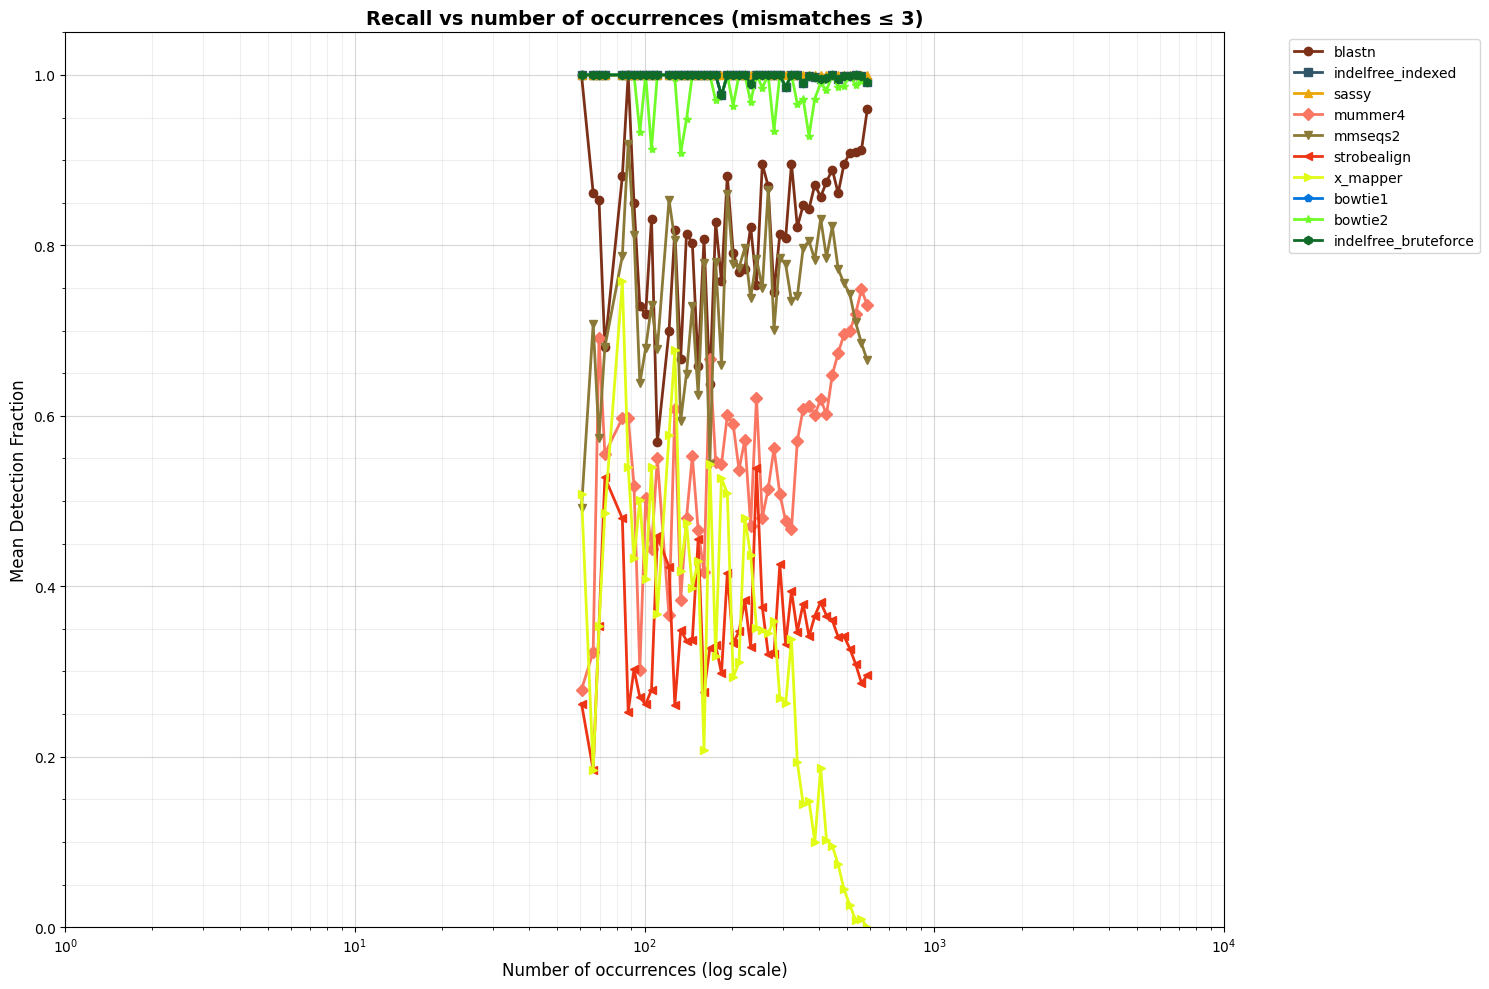

✓ Saved recall vs occurrences plots to: results/simulated/ns_500_nc_5000_HIGH_INSERTION_RATE/plots


In [14]:
# Create recall vs occurrences plots for HIGH_INSERTION_RATE simulation

# Using mismatches ≤ 3 (most stringent threshold commonly used)
high_ins_tools_list = high_ins_results['tool'].unique().to_list()
print(f"Tools in HIGH_INSERTION_RATE: {high_ins_tools_list}")

# Create output directory
high_ins_occ_output_dir = f"{high_ins_sim_dir}/plots"
os.makedirs(high_ins_occ_output_dir, exist_ok=True)

# Plot for mismatches ≤ 3
plot_combined_recall_vs_occurrences(
    results_df=high_ins_results,
    tools_list=high_ins_tools_list,
    n_high_occ_bins=3,
    output_prefix=f'{high_ins_occ_output_dir}/recall_vs_occurrences',
    max_bin=3,
    n_bins=150,
    color_dict=tool_colors,
    exact_or_max="max",
    plot_mismatches=[3]
)

print(f"✓ Saved recall vs occurrences plots to: {high_ins_occ_output_dir}")

In [17]:
# Side-by-side comparison: Primary vs High Insertion Rate at threshold=3
threshold_3_primary = tools_only.filter(pl.col('threshold') == 3).with_columns(
    pl.lit(PRIMARY_SIM).alias('simulation')
)

threshold_3_high_ins = high_ins_tools.filter(pl.col('threshold') == 3).with_columns(
    pl.lit(HIGH_INS_SIM).alias('simulation')
)

combined_compare = pl.concat([threshold_3_primary, threshold_3_high_ins])

# Convert to dict for plotting
compare_data = combined_compare.select(['tool', 'simulation', 'recall_augmented']).to_dict(as_series=False)

comparison_chart = (
    ggplot(compare_data, aes(x='tool', y='recall_augmented', fill='simulation')) +
    geom_bar(stat='identity', position='dodge') +
    scale_y_continuous(limits=[0, 1.05]) +
    labs(
        x='Tool',
        y='Recall (Augmented)',
        title='Tool Recall Comparison: Primary vs High Insertion Rate (Hamming=<3)',
        fill='Simulation'
    ) +
    ggsize(800, 400) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, face='bold'),
        axis_text_x=element_text(angle=45, hjust=1),
        legend_position='top'
    )
)
#save

comparison_chart

## Tool Recall Rankings Across Multiple Simulations

Compare how tools rank across different simulation sizes based on recall (augmented).

In [13]:
# Load threshold=3 results from all simulations
all_sims_data = []

# Exclude the real baseline
exclude_sims = ['ns_3826979_nc_421431_real_baseline',"ns_100_nc_50000"]

for sim_prefix in SIMULATION_NAMES.keys():
    # print(f"Processing {sim_prefix}...", end=' ')
    if sim_prefix in exclude_sims:
        continue
        
    sim_dir = f"results/simulated/{sim_prefix}"
    df = load_performance_results(sim_dir, DISTANCE_METRIC, 3)
    # print(f"Loaded {sim_prefix}: ", end='')
    # print(f"shape={df.shape}" if df is not None else "No data")

    if df is not None:
        # Filter out aggregate tool
        df = df.filter(pl.col('tool') != 'all_tools_combined')
        df = df.with_columns([
            pl.lit(sim_prefix).alias('simulation'),
            pl.lit(SIMULATION_NAMES[sim_prefix]).alias('sim_description')
        ])
        # df = df.select(pl.col([ "tool", "planned_true_positives", "invalid_alignments", "positives_not_in_plan", "false_negatives_planned", "ground_truth_planned", "ground_truth_augmented", "all_true_positives", "precision_planned", "recall_planned", "false_negatives_augmented", "precision_augmented", "recall_augmented", "simulation", "sim_description"
                    # ]))
    
        all_sims_data.append(df)

all_sims_combined = pl.concat(all_sims_data)

print(f"Loaded data from {len(all_sims_data)} simulations")
print(f"Total rows: {all_sims_combined.shape[0]}")
print(f"Simulations: {all_sims_combined['simulation'].unique().to_list()}")

Performance results not found: results/simulated/ns_500000_nc_100000/performance_results_hamming_mm3.tsv


  Adding tools with 0 matches to performance_results_hamming_mm3.tsv: ['minimap2']
Loaded data from 5 simulations
Total rows: 55
Simulations: ['ns_100000_nc_20000', 'ns_500_nc_5000_HIGH_INSERTION_RATE', 'ns_75000_nc_5000', 'ns_50000_nc_5000', 'ns_100000_nc_10000']


# Pivot table showing recall across simulations
recall_pivot = all_sims_combined.select(['tool', 'simulation', 'recall_augmented']).pivot(
    index='tool',
    on='simulation',
    values='recall_augmented'
).sort('tool')

recall_pivot

In [ ]:
# Create recall heatmap across all simulations
heatmap_data = all_sims_combined.select(['tool', 'simulation', 'recall_augmented']).to_dict(as_series=False)

# Add formatted labels for display
import polars as pl
heatmap_df = all_sims_combined.select(['tool', 'simulation', 'recall_augmented'])
heatmap_df = heatmap_df.with_columns(
    pl.col('recall_augmented').round(2).cast(pl.Utf8).alias('label')
)
# heatmap_data = heatmap_df.to_dict(as_series=False)

recall_heatmap = (
    ggplot(heatmap_df, aes(x='simulation', y='tool', fill='recall_augmented')) +
    geom_tile(color='white', size=0.5) +
    geom_text(aes(label='label'), color='white', size=6, fontface='bold') +
    scale_fill_gradient(low='#440154', high='#FDE724', limits=[0, 1], name='Recall\n(Augmented)') +
    labs(
        x='Simulation',
        y='Tool',
        title='Tool Recall Across Simulations (Hamming Distance=<3)'
    ) +
    ggsize(900, 600) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, face='bold'),
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
#save


# Save mean recall visualization
mean_recall_output_dir = f"{simulated_base_dir}/plots"
os.makedirs(mean_recall_output_dir, exist_ok=True)
recall_heatmap.to_html(f"{mean_recall_output_dir}/tool_recall_heatmap_hamming3.html")
recall_heatmap.to_svg(f"{mean_recall_output_dir}/tool_recall_heatmap_hamming3.svg")
recall_heatmap



## Tool Recall Summary Statistics

Calculate mean recall across all simulations to identify best performers.

In [15]:
# Calculate mean and std recall across simulations
tool_summary = all_sims_combined.group_by('tool').agg([
    pl.col('recall_augmented').mean().alias('mean_recall'),
    pl.col('recall_augmented').std().alias('std_recall'),
    pl.col('all_true_positives').sum().alias('total_tp'),
    pl.col('false_negatives_augmented').sum().alias('total_fn'),
]).sort('mean_recall', descending=True)

tool_summary

tool,mean_recall,std_recall,total_tp,total_fn
str,f64,f64,i64,i64
"""indelfree_indexed""",1.0,0.0,1169650,0
"""indelfree_bruteforce""",1.0,0.0,1169650,0
"""bowtie1""",1.0,0.0,1169650,0
"""sassy""",0.999978,0.000017,1169625,25
"""bowtie2""",0.977158,0.000684,1143139,26511
"""blastn""",0.780153,0.001185,912164,257486
"""mmseqs2""",0.683416,0.08627,763497,406153
"""strobealign""",0.496743,0.17347,505144,664506
"""mummer4""",0.477306,0.012812,563393,606257


In [29]:
# Visualize mean recall with error bars
error_bar_data = all_sims_combined.group_by('tool').agg([
    pl.col('recall_augmented').mean().alias('mean_recall'),
    pl.col('recall_augmented').std().alias('std_recall'),
    (pl.col('recall_augmented').mean() + pl.col('recall_augmented').std()).alias("std_max"),
    (pl.col('recall_augmented').mean() - pl.col('recall_augmented').std()).alias("std_min")
])
error_bar_data = error_bar_data.with_columns(
    pl.when(pl.col('std_min') < 0).then(pl.lit(0)).otherwise(pl.col('std_min')).alias('std_min'),
    pl.when(pl.col('std_max') > 1).then(pl.lit(1)).otherwise(pl.col('std_max')).alias('std_max')

)
# Convert to dict for plotting
error_data = error_bar_data.to_dict(as_series=False)

# Create error bar chart with points
chart = (
    ggplot(error_bar_data, aes(x='tool', y='mean_recall')) +
    geom_errorbar(aes(ymin="std_min", ymax="std_max"), width=0.2) +
    geom_point(aes(color='tool',), size=4, shape=19) +
    scale_color_manual(values=tool_colors) +
    scale_shape_manual(values=tool_shapes, name='tool') +
    scale_y_continuous(limits=[0, 1.05]) +
    labs(
        x='Tool',
        y='Recall (mean ± std dev)',
        title='Mean Recall ± Std Dev Across Simulations (Hamming Distance ≤ 3)'
    ) +
    ggsize(700, 400) +
    theme_minimal() +
    theme(      
        plot_title=element_text(size=14, face='bold'),
        axis_text_x=element_text(angle=45, hjust=1),
        legend_position='none'
    )
)


# Save mean recall visualization
mean_recall_output_dir = f"{simulated_base_dir}/plots"
os.makedirs(mean_recall_output_dir, exist_ok=True)
chart.to_html(f"{mean_recall_output_dir}/mean_recall_error_bars.html")
chart.to_svg(f"{mean_recall_output_dir}/mean_recall_error_bars.svg")
print(error_bar_data)
chart.show()


shape: (11, 5)
┌──────────────────────┬─────────────┬────────────┬──────────┬──────────┐
│ tool                 ┆ mean_recall ┆ std_recall ┆ std_max  ┆ std_min  │
│ ---                  ┆ ---         ┆ ---        ┆ ---      ┆ ---      │
│ str                  ┆ f64         ┆ f64        ┆ f64      ┆ f64      │
╞══════════════════════╪═════════════╪════════════╪══════════╪══════════╡
│ sassy                ┆ 0.999978    ┆ 0.000017   ┆ 0.999995 ┆ 0.99996  │
│ mmseqs2              ┆ 0.683416    ┆ 0.08627    ┆ 0.769687 ┆ 0.597146 │
│ mummer4              ┆ 0.477306    ┆ 0.012812   ┆ 0.490118 ┆ 0.464494 │
│ indelfree_bruteforce ┆ 1.0         ┆ 0.0        ┆ 1.0      ┆ 1.0      │
│ indelfree_indexed    ┆ 1.0         ┆ 0.0        ┆ 1.0      ┆ 1.0      │
│ bowtie1              ┆ 1.0         ┆ 0.0        ┆ 1.0      ┆ 1.0      │
│ minimap2             ┆ 0.000214    ┆ 0.000126   ┆ 0.000339 ┆ 0.000088 │
│ bowtie2              ┆ 0.977158    ┆ 0.000684   ┆ 0.977842 ┆ 0.976474 │
│ strobealign          

In [18]:
# Create pairwise recall differences at threshold=3 for primary simulation
threshold_3_primary = tools_only.filter(pl.col('threshold') == 3)

# Create difference matrix
tools_list = sorted(threshold_3_primary['tool'].unique().to_list())
recall_dict = {row['tool']: row['recall_augmented'] for row in threshold_3_primary.to_dicts()}

# Build difference matrix (row - column)
diff_matrix = []
for tool_row in tools_list:
    row_data = {'tool': tool_row}
    for tool_col in tools_list:
        if tool_row == tool_col:
            row_data[tool_col] = 0.0
        else:
            row_data[tool_col] = recall_dict[tool_row] - recall_dict[tool_col]
    diff_matrix.append(row_data)

diff_df = pl.DataFrame(diff_matrix)
diff_df

tool,blastn,bowtie1,bowtie2,indelfree_bruteforce,indelfree_indexed,minimap2,mmseqs2,mummer4,sassy,strobealign,x_mapper
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""blastn""",0.0,-0.220081,-0.196737,-0.220081,-0.220081,0.779612,0.059308,0.31002,-0.220041,0.234509,0.366967
"""bowtie1""",0.220081,0.0,0.023344,0.0,0.0,0.999694,0.279389,0.530102,0.00004,0.454591,0.587048
"""bowtie2""",0.196737,-0.023344,0.0,-0.023344,-0.023344,0.97635,0.256045,0.506758,-0.023304,0.431247,0.563704
"""indelfree_bruteforce""",0.220081,0.0,0.023344,0.0,0.0,0.999694,0.279389,0.530102,0.00004,0.454591,0.587048
"""indelfree_indexed""",0.220081,0.0,0.023344,0.0,0.0,0.999694,0.279389,0.530102,0.00004,0.454591,0.587048
"""minimap2""",-0.779612,-0.999694,-0.97635,-0.999694,-0.999694,0.0,-0.720305,-0.469592,-0.999654,-0.545103,-0.412646
"""mmseqs2""",-0.059308,-0.279389,-0.256045,-0.279389,-0.279389,0.720305,0.0,0.250713,-0.279349,0.175202,0.307659
"""mummer4""",-0.31002,-0.530102,-0.506758,-0.530102,-0.530102,0.469592,-0.250713,0.0,-0.530062,-0.075511,0.056946
"""sassy""",0.220041,-0.00004,0.023304,-0.00004,-0.00004,0.999654,0.279349,0.530062,0.0,0.454551,0.587008


In [ ]:
# Visualize recall difference matrix
# Melt for heatmap

diff_long = diff_df.unpivot(
    index='tool',
    on=tools_list,
    variable_name='tool_compared',
    value_name='recall_diff'
)

# Convert to dict for plotting
diff_data = diff_long.to_dict(as_series=False)

diff_heatmap = (
    ggplot(diff_data, aes(x='tool_compared', y='tool', fill='recall_diff')) +
    geom_tile(color='white', size=0.5) +
    geom_text(aes(label='recall_diff'), label_format=".2",color='white', size=6, fontface='bold',) +

    scale_fill_gradient2(low='#2166AC', mid='#F7F7F7', high='#B2182B', 
                         midpoint=0, limits=[-1, 1], name='Recall\nDifference') +
    labs(
        x='Tool (compared to)',
        y='Tool',
        title=f'Recall Differences (row minus column) at Hamming<=3 ({PRIMARY_SIM})'
    ) +
    ggsize(800, 800) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, face='bold'),
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
# save
mean_recall_output_dir = f"{simulated_base_dir}/plots"
os.makedirs(mean_recall_output_dir, exist_ok=True)
diff_heatmap.to_html(f"{mean_recall_output_dir}/tool_recall_diff_heatmap_ns_100000_nc_20000_hamming_3.html")
diff_heatmap.to_svg(f"{mean_recall_output_dir}/tool_recall_diff_heatmap_ns_100000_nc_20000_hamming_3.svg")

diff_heatmap

## Summary

This notebook analyzed tool-specific recall performance on simulated CRISPR spacer data:

1. **Hamming Distance Threshold Analysis**: Evaluated recall allowing up to N hamming distance (0-5), revealing which tools cannot perform above certain thresholds (>3 bowtie1)
2. **Primary Simulation** ({ns_100000_nc_20000}): Largest set we currently tested in current version.
3. **High Insertion Rate Simulation** ({HIGH_INS_SIM}): Tests tool performance with high occurrence rate spacers (i.e. spacers that appear many times in the contigs, by our design (simulation plan)).
4. **Cross-Simulation Comparison**: Most tools had very low variation (< 0.05), in observed recall across all simulation. The notable excpetion are strobealign (std = 0.173), mmseqs (std = 0.086) and x-mapper(std = 0.178). Otherwise, recall seems very consistent regardless of different dataset sizes.
